# Applying Data Science Model Development (LSTM)

## 1. Preprocess the data

In [8]:
# === Step 0: Import Libraries ===
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import numpy as np
import optuna
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [9]:
# === Step 1: Data Preparation ===
# load the data
df = pd.read_csv("Final_v2_processed.csv")

# Convert 'addr_state' from string to numeric
le = LabelEncoder()
df["addr_state"] = le.fit_transform(df["addr_state"])

# Replace 'df' with your actual DataFrame
target_col = "loan_status"
feature_cols = [col for col in df.columns if col != target_col and col != "id"]

# Extract features and target
X = df[feature_cols].values
y = df[target_col].values

# Standardize features
#scaler = StandardScaler()
#X = scaler.fit_transform(X)

# Reshape for LSTM input: (samples, sequence_length, input_size)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Custom Dataset class
class LoanDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)  # long type for classification

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create Dataset instances
train_dataset = LoanDataset(X_train, y_train)
val_dataset = LoanDataset(X_val, y_val)

## 2. Define the LSTM model

In [10]:
# === Step 2: Define LSTM Model ===
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)             # LSTM output
        out = out[:, -1, :]               # Use only last time step
        out = self.fc(out)                # Final classification layer
        return out

## 3. Tune hyperparameters by Optuna

In [11]:
# === Step 3: Optuna Hyperparameter Tuning ===
def objective(trial):
    hidden_size = trial.suggest_int("hidden_size", 32, 128)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    model = LSTMClassifier(input_size=1, hidden_size=hidden_size,
                           num_layers=num_layers, num_classes=2, dropout=dropout)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(10):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.numpy())
            y_true.extend(y_batch.numpy())

    # F1 score as target
    return 1 - f1_score(y_true, y_pred, average="weighted")

# Run Optuna
study = optuna.create_study()
study.optimize(objective, n_trials=20)
best_params = study.best_trial.params
print("Best hyperparameters:", best_params)

[I 2025-03-25 19:04:11,644] A new study created in memory with name: no-name-62567eef-f35a-41d3-b431-75d9e6ba1b6e
C:\Users\teppe\anaconda3\envs\test_env\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.334430572496684 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2025-03-25 19:09:12,186] Trial 0 finished with value: 0.030621378659259846 and parameters: {'hidden_size': 52, 'num_layers': 1, 'dropout': 0.334430572496684, 'lr': 0.007354235215153561, 'batch_size': 128}. Best is trial 0 with value: 0.030621378659259846.
C:\Users\teppe\anaconda3\envs\test_env\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.48214481798981607 and num_layers=1
  warnings.warn("dropou

Best hyperparameters: {'hidden_size': 71, 'num_layers': 2, 'dropout': 0.0818282843315816, 'lr': 0.00037658706836813115, 'batch_size': 32}


## 4. Re-learn with the optimized parameters

In [19]:
# === Step 4: Train Final Model with Best Params ===
batch_size = best_params['batch_size']
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

model = LSTMClassifier(input_size=1,
                       hidden_size=best_params['hidden_size'],
                       num_layers=best_params['num_layers'],
                       num_classes=2,
                       dropout=best_params['dropout'])

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])

# Initialize early stopping variables
patience = 5
min_delta = 1e-4
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

# Lists to store loss per epoch
train_losses = []
val_losses = []

# Updated training loop with loss tracking
for epoch in range(20):
    model.train()
    running_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loss
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Check early stopping condition
    if avg_val_loss + min_delta < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()  # Save best model
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        early_stop = True
        break

# After training, optionally load the best model weights
model.load_state_dict(best_model_state)

Epoch 1 - Train Loss: 0.4511, Val Loss: 0.4491
Epoch 2 - Train Loss: 0.4497, Val Loss: 0.4490
Epoch 3 - Train Loss: 0.2184, Val Loss: 0.1040
Epoch 4 - Train Loss: 0.0980, Val Loss: 0.0981
Epoch 5 - Train Loss: 0.0914, Val Loss: 0.0959
Epoch 6 - Train Loss: 0.0890, Val Loss: 0.0862
Epoch 7 - Train Loss: 0.0870, Val Loss: 0.0846
Epoch 8 - Train Loss: 0.0853, Val Loss: 0.0885
Epoch 9 - Train Loss: 0.0842, Val Loss: 0.0839
Epoch 10 - Train Loss: 0.0844, Val Loss: 0.0821
Epoch 11 - Train Loss: 0.0821, Val Loss: 0.0832
Epoch 12 - Train Loss: 0.0814, Val Loss: 0.0799
Epoch 13 - Train Loss: 0.0823, Val Loss: 0.0803
Epoch 14 - Train Loss: 0.0805, Val Loss: 0.0875
Epoch 15 - Train Loss: 0.0797, Val Loss: 0.0800
Epoch 16 - Train Loss: 0.0803, Val Loss: 0.0851
Epoch 17 - Train Loss: 0.0802, Val Loss: 0.0775
Epoch 18 - Train Loss: 0.0784, Val Loss: 0.0786
Epoch 19 - Train Loss: 0.0794, Val Loss: 0.0805
Epoch 20 - Train Loss: 0.0777, Val Loss: 0.0771


<All keys matched successfully>

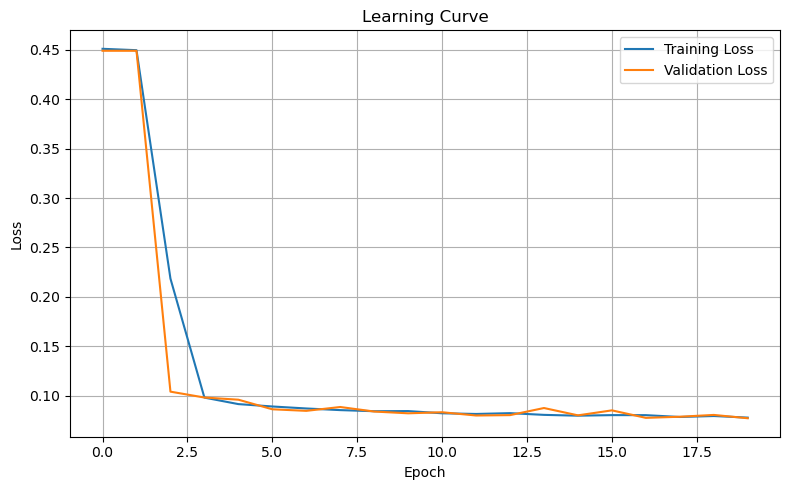

In [20]:
# Plot learning curve
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 5. Evaluate the model


--- Evaluation on Training Data ---
AUC-ROC:     0.9899
F1-Score:    0.9139
Precision:   0.9789
Recall:      0.8570
Confusion Matrix:
[[115866    428]
 [  3307  19822]]


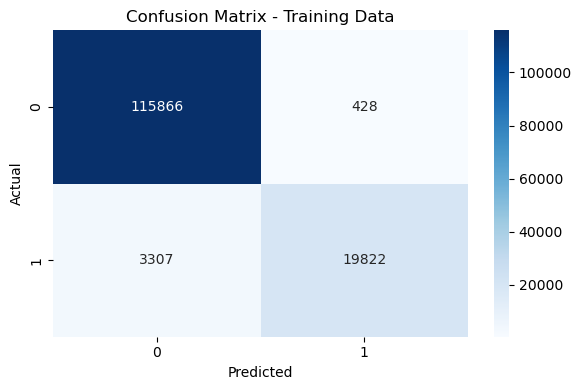


--- Evaluation on Validation Data ---
AUC-ROC:     0.9891
F1-Score:    0.9120
Precision:   0.9795
Recall:      0.8532
Confusion Matrix:
[[28975   103]
 [  848  4930]]


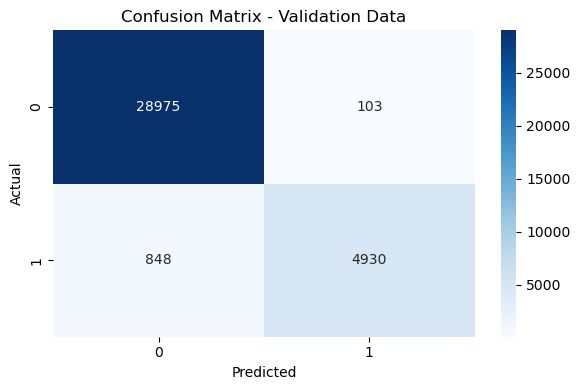

In [21]:
# === Step 5: Evaluation Metrics ===
def evaluate_model(model, data_loader, dataset_name=""):
    model.eval()
    y_true, y_pred, y_prob = [], [], []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            _, preds = torch.max(outputs, 1)
            y_true.extend(y_batch.numpy())
            y_pred.extend(preds.numpy())
            y_prob.extend(probs.numpy())

    # Compute metrics
    auc = roc_auc_score(y_true, y_prob)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Print results
    print(f"\n--- Evaluation on {dataset_name} ---")
    print(f"AUC-ROC:     {auc:.4f}")
    print(f"F1-Score:    {f1:.4f}")
    print(f"Precision:   {precision:.4f}")
    print(f"Recall:      {recall:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# Run on both datasets
evaluate_model(model, train_loader, "Training Data")
evaluate_model(model, val_loader, "Validation Data")

## 6. Save the model

In [22]:
# === Step 6: Save Model and Scaler ===
# Save model weights
torch.save(model.state_dict(), "lstm_model.pth")

# Save scaler used for input normalization
#joblib.dump(scaler, "scaler.pkl")

# === Optional: Load Model and Scaler Later ===
# model = LSTMClassifier(input_size=1,
#                        hidden_size=best_params['hidden_size'],
#                        num_layers=best_params['num_layers'],
#                        num_classes=2,
#                        dropout=best_params['dropout'])
# model.load_state_dict(torch.load("lstm_model.pth"))
# model.eval()
# scaler = joblib.load("scaler.pkl")